# 0. 버전확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.17.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1. 데이터 수집하기
### new_train.csv사용

# Step 2. 데이터 전처리하기
### 5) 데이터 증강 외 모두 적용

#### **1) 한글 불용어 처리  2) 구두점 처리  3) 중복 공백 제거  4) 양쪽 공백 제거   6) 임베딩 방식(모델에서 처리해줌)**

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [4]:
train_data_path ="/content/drive/MyDrive/dlthon/new_train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
data = train_data

In [6]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 12092


In [7]:
# 중복 확인
from collections import Counter

data_counts = Counter(data)
duplicates = {item: count for item, count in data_counts.items() if count > 1}

print("중복된 데이터:", duplicates)  # {1: 2} (1이 2번 등장)

중복된 데이터: {}


In [8]:
# 'class' 열과 'idx' 열에 누락값 확인
missing_class = data['class'].isnull().any()
missing_idx = data['idx'].isnull().any()

print("class 열에 누락값이 있습니까?", missing_class)  # True (누락값 있음)
print("idx 열에 누락값이 있습니까?", missing_idx)      # True (누락값 있음)


class 열에 누락값이 있습니까? False
idx 열에 누락값이 있습니까? False


In [9]:
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []

    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)

        # 양쪽 공백 제거
        sentence = sentence.strip()

        processed_texts.append(sentence)

    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []

    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()

        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]

        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))

    return filtered_texts


# conversation 열에 대해서만 전처리 및 불용어 제거 적용
data['conversation_processed'] = preprocess_korean_text(data['conversation'])
data['conversation_filtered'] = remove_stopwords(data['conversation_processed'], stopwords)

# 결과 확인
print(data[['conversation', 'conversation_processed', 'conversation_filtered']].head())


                                        conversation  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...   
1  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...   
2  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...   
3  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...   
4  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...   

                              conversation_processed  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...   
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...   
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...   
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...   
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...   

                               conversation_filtered  
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...  
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...  
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...  
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...  
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발..

In [10]:
data

,idx,class,conversation,conversation_processed,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...,...,...
12087,12087,일반,미안하다... 나 내일 회사 하루 쉬려고. 회사를? 어...너무 힘들어서 하루 쉬고...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 이 오밤중에? 난 정말 나간다. 애들처럼 왜 이러냐고? 동네 창피...,아~엄마 뭐하는데 이 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네...,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가, 자 임마. 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가. 겁...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어, 왜 일어나있어? 힘든데 누워있지. 아니, 이젠 괜찮아 오빠. 뭐가 괜찮아? 어...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [11]:
# Q열과 A열 삭제
data = data.drop(columns=['conversation', 'conversation_processed'])
data

,idx,class,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [13]:
# 열 이름 변경
data = data.rename(columns={'conversation_filtered': 'conversation'})
data


,idx,class_label,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [14]:
# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})
data

,idx,class_label,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


# (사용x)Step 3. SubwordTextEncoder 사용하기
#### BERT의 토크나이저는 이미 광범위한 텍스트 데이터로 **학습된 단어장을 포함하고 있으며, 문장을 정수로 인코딩하고 패딩하는 기능도 포함**되어 있습니다.  

KLUE-BERT와 같은 사전 학습된 BERT 모델을 사용하면,  
**단어장을 만들고 정수 인코딩 및 패딩을 처리하는 과정은 필요하지 않습니다.**



#### 1. 단어장(Vocabulary) 만들기

In [ ]:
import tensorflow_datasets as tfds

# 데이터프레임에서 questions와 answers 열을 리스트로 변환
conversation = data['conversation'].tolist()
class_label = data['class_label'].tolist()

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation + class_label, target_vocab_size=2**14)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

16144


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [ ]:
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(conversation[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(class_label[21])))


정수 인코딩 후의 21번째 질문 샘플: [9, 579, 456, 4801, 150, 64, 12602, 127, 1, 6755, 28, 17, 31, 1560, 1, 25, 18, 12091, 15387, 207, 537, 137, 2674, 1, 7, 17, 6121, 872, 2, 18, 12091, 4923, 2020, 2, 68, 9565, 15918, 64, 8367, 164, 1487, 2443, 3358, 2, 1119, 37, 872, 2, 11394, 11610, 1, 25, 31, 9579, 120, 1, 833, 12091, 5675, 1462, 2, 860, 617, 5]
정수 인코딩 후의 21번째 답변 샘플: [87, 13]


대화의 최소 길이 : 8
대화의 최대 길이 : 305
대화의 평균 길이 : 55.55946080052927


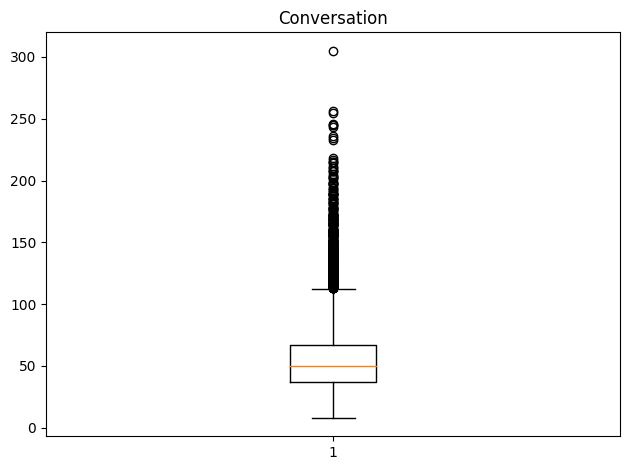

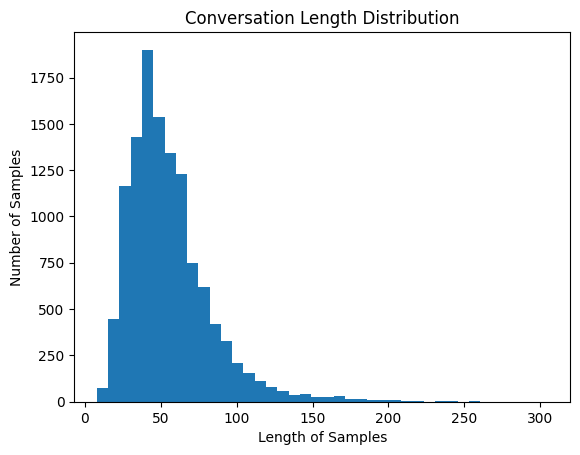

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 길이 분포 출력
conversation_len = [len(s.split()) for s in data['conversation']]
class_label_len = [len(s.split()) for s in data['class_label']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 120
print(MAX_LENGTH)

120


In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 140 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 140으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

# 정수 인코딩 과정을 수행하면서 샘플의 길이가 140을 넘는 경우는 샘플들을 필터링함. 단어장의 크기와 샘플의 개수를 확인
import tensorflow as tf
conversation, class_label = tokenize_and_filter(conversation, class_label)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 16144
필터링 후의 대화 샘플 개수: 11062


In [ ]:
print(conversation[2])
print(class_label[2])

[16142     9   391 11306  6169 15918   442     2  2406  1833  3499  4400
  1052     1   646     1  2137 15586 15918  6896     1    45   855    38
   192  3330 15873 15934  1519     2    29   539    21 15873 15934    14
   180  1936    11     2     9  6042    14 14876  1456     1  8171    16
 12938   172 12115 10566   665     2 13832  2343  4425  5440  3327     1
   266  5750    28  3889   299  5377  7767     1  1259   698    21  3169
    14  5252   127     2   620  1664   152  5289  1015     2    81  5679
  3519    26     1  6847 15918  5279   840     1   123   249  4366   480
   102 16143     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[16142    79    33    13 16143     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': conversation,
        'dec_inputs': class_label[:, :-1]
    },
    {
        'outputs': class_label[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

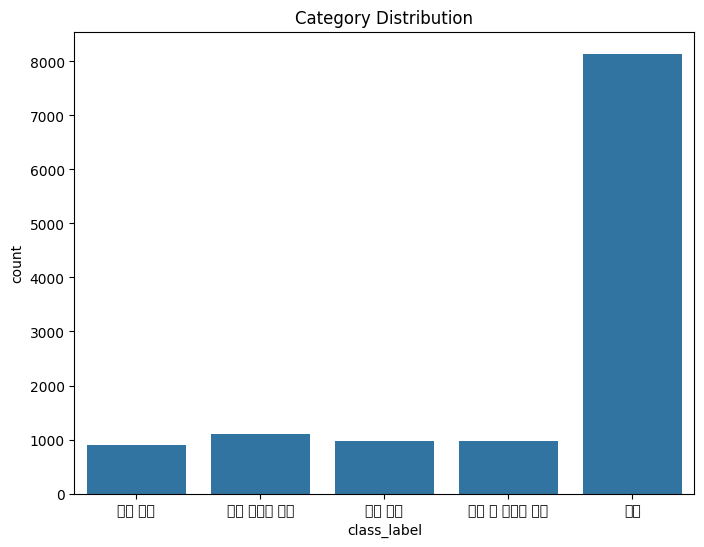

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='class_label', data=data)
plt.title('Category Distribution')
plt.show()


In [ ]:

'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# y_true는 실제 라벨
y_true = np.array(class_label)  # 실제 라벨, 예시에서는 class_label

# y_pred는 모델을 통해 예측된 라벨
y_pred = []  # 빈 리스트로 시작, 모델 예측 결과를 이곳에 추가

# 모델을 사용해 각 문장에 대한 예측 라벨을 얻음
for encoded_sentence in conversation:  # 이미 정수 인코딩된 데이터를 사용
    inputs = np.expand_dims(encoded_sentence, axis=0)  # 모델 입력에 맞게 차원 확장
    outputs = model(inputs)  # 모델 예측
    pred = np.argmax(outputs.logits, axis=-1)  # 가장 높은 확률을 가진 라벨 선택
    y_pred.append(pred.numpy()[0])  # 리스트에 예측 값 추가

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
'''

'\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nimport numpy as np\n\n# y_true는 실제 라벨\ny_true = np.array(class_label)  # 실제 라벨, 예시에서는 class_label\n\n# y_pred는 모델을 통해 예측된 라벨\ny_pred = []  # 빈 리스트로 시작, 모델 예측 결과를 이곳에 추가\n\n# 모델을 사용해 각 문장에 대한 예측 라벨을 얻음\nfor encoded_sentence in conversation:  # 이미 정수 인코딩된 데이터를 사용\n    inputs = np.expand_dims(encoded_sentence, axis=0)  # 모델 입력에 맞게 차원 확장\n    outputs = model(inputs)  # 모델 예측\n    pred = np.argmax(outputs.logits, axis=-1)  # 가장 높은 확률을 가진 라벨 선택\n    y_pred.append(pred.numpy()[0])  # 리스트에 예측 값 추가\n\n# 혼동 행렬 생성\ncm = confusion_matrix(y_true, y_pred)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm)\ndisp.plot()\nplt.show()\n'

In [ ]:
from sklearn.decomposition import PCA

ValueError: 'c' argument has 120 elements, which is inconsistent with 'x' and 'y' with size 11062.

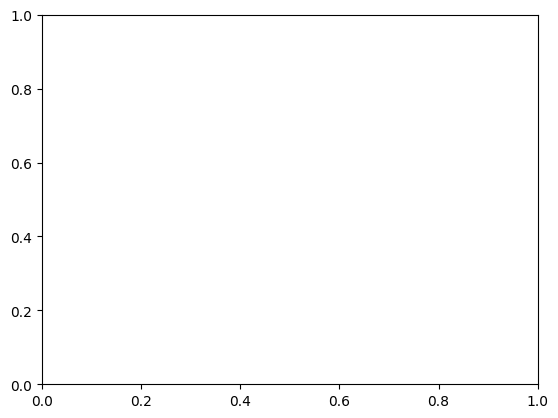

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(conversation)  # conversation이 임베딩된 데이터

# Assuming class_label has shape (120, 11062), and you need labels for each data point:
class_label_reshaped = class_label[0] # Select the first row of class_label, assuming it contains the correct labels.

plt.scatter(components[:, 0], components[:, 1], c=class_label_reshaped)  # class_label이 카테고리 라벨
plt.title('PCA of Data')
plt.show()

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(conversation)  # conversation이 임베딩된 데이터

# Assuming class_label has shape (120, 11062), and you need labels for each data point:
class_label_reshaped = class_label.T[0] # Transpose class_label and select the first row

plt.scatter(components[:, 0], components[:, 1], c=class_label_reshaped)  # class_label이 카테고리 라벨
plt.title('PCA of Data')
plt.show()

In [ ]:
# !pip install wandb

In [ ]:
import wandb
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(project="dim_reduction_example")


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import wandb
import numpy as np

# WandB 프로젝트 초기화
wandb.init(project="dim_reduction_example")

# 예시 데이터: conversation에 정수 인코딩된 데이터가 있다고 가정
# conversation = np.random.randn(100, 300)  # 임의 데이터 예시

# PCA 적용
pca = PCA(n_components=2)
pca_components = pca.fit_transform(conversation)

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(conversation)

# 시각화 결과를 WandB에 기록
wandb.log({
    "PCA Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(pca_components[:, 0], pca_components[:, 1])],
                    columns=["PC1", "PC2"]),
        "PC1", "PC2", title="PCA of Data"
    ),
    "t-SNE Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(tsne_components[:, 0], tsne_components[:, 1])],
                    columns=["Dim1", "Dim2"]),
        "Dim1", "Dim2", title="t-SNE of Data"
    )
})


# step 4. 모델 정의

#### 9-4. KLUE-BERT 가져오기

In [ ]:
# !pip install transformers

In [ ]:
# !pip install transformers sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## KLUE-BERT와 t-SNE를 사용한 시각화

주요 단계 요약:
1. KLUE-BERT 모델과 토크나이저 로드  
2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환  
3. t-SNE를 사용하여 차원 축소  
4. t-SNE 시각화  

> t-SNE, 	**작은 데이터셋**의 클러스터링된 패턴을 탐색하거나, 데이터의 **국소적 특성**을 시각화하기 좋음.


**작은 데이터셋인가?**
-> 크기 측면에서 보면, 데이터셋의 크기가 12,092개의 샘플로 되어 있는 중간 크기의 데이터셋  
=> (t-SNE를 사용하는 데 무리가 없는 크기, 매우 크지는 않아서 빠르게 처리가능)



**국소적 특성**
-> 협박과 관련된 문장들이 같은 공간에 모이고, 갈취와 직장 내 괴롭힘은 다른 영역에 모이는지 등 우리의 상식과 비슷한지 확인하고자 함.  
-> 세부적으로 어떤 문장들이 더 유사한지를 탐구

### 1.KLUE-BERT 모델과 토크나이저 로드

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# KLUE-BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = BertModel.from_pretrained("klue/bert-base") # BertForSequenceClassification 대신 BertModel 사용

# model = BertForSequenceClassification.from_pretrained("klue/bert-base")
# ERROR : AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환  

시간 진짜 오래 걸림;;;;
image.png
image.png

In [ ]:
# 텍스트를 BERT 임베딩으로 변환하는 함수
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # 모델 학습을 하지 않으므로 gradient 계산을 하지 않음
        outputs = model(**inputs)
    # CLS 토큰의 임베딩만 사용 (배치에서 첫 번째 토큰)
    return outputs.last_hidden_state[:, 0, :].numpy()

# 데이터에서 텍스트 열을 사용하여 BERT 임베딩 계산
embeddings = np.array([get_bert_embeddings(text) for text in data['conversation']])


In [ ]:
# t-SNE로 3차원 축소
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(embeddings.squeeze())

# t-SNE 결과를 WandB로 로그
wandb.log({
    "3D t-SNE Visualization": wandb.plot.scatter(
        wandb.Table(data=[[x, y, z, label] for x, y, z, label in zip(
            tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], data['class']
        )],
        columns=["TSNE-1", "TSNE-2", "TSNE-3", "class"]),
        "TSNE-1", "TSNE-2", "TSNE-3", title="3D t-SNE Visualization of KLUE-BERT Embeddings")
})

# wandb.finish()로 세션 종료
wandb.finish()

In [ ]:
# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings.squeeze())

# t-SNE 결과를 데이터프레임에 추가
data['tsne_1'] = tsne_results[:, 0]
data['tsne_2'] = tsne_results[:, 1]

# t-SNE 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="class",  # 'class' 열을 사용하여 카테고리별로 색상 구분
    palette=sns.color_palette("hsv", as_cmap=True),
    data=data,
    legend="full"
)
plt.title('t-SNE Visualization of KLUE-BERT Embeddings')
plt.show()

## 파이프라인을 이용한 테스트

In [ ]:
# KLUE-BERT 토크나이저로 토큰화 및 인코딩
inputs = tokenizer(
    processed_texts.tolist(),  # 전처리된 텍스트 리스트
    return_tensors="pt",       # PyTorch 텐서로 반환
    padding=True,              # 패딩 적용
    truncation=True,           # 최대 길이 초과시 잘라내기
    max_length=128             # 최대 길이 설정 (128 토큰)
)

In [ ]:
# KLUE-BERT 모델에 입력하여 임베딩 또는 예측값 얻기
with torch.no_grad():  # 학습이 아닌 예측을 수행하므로 gradient 계산하지 않음
    outputs = model(**inputs)

# 모델 출력 확인
# CLS 토큰에 해당하는 임베딩 벡터 추출
cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 임베딩


In [ ]:
# 파이프라인을 이용한 테스트
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)

In [ ]:
# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("klue/bert-base")
print(model.config.id2label)


In [ ]:
output = predict('아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네')

In [ ]:
output = predict('우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.')

In [ ]:
output = predict('너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요')

#### 위에건 일반 대화 아닌가? 애매함ㅎ. 2 epochs에서는 일반 대화로 분류함

In [ ]:
output = predict('국희씨 네? 이번주말에 뭐해? 애들이랑 키즈카페 가기러했어요 어 사실 나도 아까 점심먹을때 들어서 알고 있었는데 확인차 물어봤어 왜그러세요? 응 우리애들이랑 국희씨 애들이랑 나이도 얼추 비슷한데 주말에 키즈카페 좀 데려가주라 네?? 실장님은 안가시구요? 어 나는 집도 좀 치우고 밀린 일좀 보게 부탁할게 하지만 제가 애들 4명이나 보기엔 우리애들 얌전하니까 너무걱정마 내가 주의줄게 그럼 주말에 우리집앞으로 와')

In [ ]:
output = predict('저기요 제가 파워블로거에 맘카페까지 활동하고 있어요.  아.네. 멋지시네요!!!! 파워블로거 분들이 쓰신글을 조금 믿음이 가더라구요. 그쵸? 와 된장찌개 진짜 잘 먹었어요. 요리 솜씨가 좋네요 이만 가보겠습니다. 저기요 손님 밥 값 지불 안 하셨는데요! 네? 저 파워블로거라니까요? 제가 홍보해드릴건데 밥은 무료로 주셔야죠 저 홍보해달라고 한 적 없는데요 와서 빨리 밥값내고 가세요. 저 홍보해달라고 한 적 없어요. 그렇게 말 번복하시면 안되죠. 엄연한 계약 사항인데. 제가 언제리뷰해달라고 했어요 그냥 멋지시다고 했죠 빨리 돈내고 가세요. 나참 어이가 없네 아주 안 좋게 적을거니까 각오하세요. 하. 그냥 돈 내지말고 가세요. 그냥 가셔도 됩니다.')

# 하이퍼파라미터 간 실험

### 1. Max length값 120->100 감소 시키기

In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 100

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': conversation,
        'dec_inputs': class_label[:, :-1]
    },
    {
        'outputs': class_label[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.05 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

epochs = 9


# epochs를 9으로 설정하고 모델을 학습합니다.
history = model.fit(dataset, epochs=epochs, verbose=1)

In [ ]:
# 손실 값 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 회고
[Positional Encoding]
positional encoding을 gpt-1처럼 embedding으로 변경하면 어떻게 될까?
transformer에서 주로 positional encoding보다 embedding이 더 성능이 잘 나올 것 같은데(단어 간의 의미 관계를 유의미한 벡터의 거리로 표현했기 때문) encoding이 주로 사용되는 이유가 embedding보다 데이터 소모 가성비가 좋아서일까?

[토크나이징 - 형태소 분석기/subwordtovector]
한국어 데이터에 주로 사용되는 형태소 분석기를 사용하여 토크나이징을 하면 성능이 어떻게 될까?

[Max length값]
사분위 값인 120을 기준으로 100 or 140 에서의 성능?

[dropout 값]
0.01 -> (0.05) -> 0.10 비교

[batch size와 buffer size]
1) epochs 수와 batch size의 관계?
2) batch size와 buffer size의 관계?

[epochs]
early stopping을 통해 최적의 epochs 수 확인

[Num_LAYERS]
인코더와 디코더의 층의 개수를 증가시킨다면?
(2) -> 4 -> 8 -> 12

[실험 수업 때 했던 파라미터 최적화 기능?]
위 기능을 사용하면 여러번 실험을 하지 않아도 파라미터 별 영향도 및 최적값을 도출해줄까? 시간을 아낄 수 있을 것 같다
